In [2]:
import os
import kagglehub
import pandas as pd
import plotly.express as px

In [3]:
data_path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")

print("Path to dataset files:", data_path)


100%|██████████| 4.38M/4.38M [00:00<00:00, 6.31MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datatattle/covid-19-nlp-text-classification/versions/1


In [4]:
train_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_train.csv"), encoding="latin1")
test_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_test.csv"), encoding="latin1")

In [5]:
print(train_df.shape, test_df.shape)

(41157, 6) (3798, 6)


Null count

In [6]:
train_df.isna().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


Seems that only location has null values. So, for visualizations involving location, we'll remove them.

Number of unique classes:

In [7]:
train_df['Sentiment'].value_counts().index

Index(['Positive', 'Negative', 'Neutral', 'Extremely Positive',
       'Extremely Negative'],
      dtype='object', name='Sentiment')

In [8]:
sentiment_counts = train_df['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
fig = px.pie(sentiment_counts, values='Count', names='Sentiment', title='Distribution of Sentiments in Training Data', hole=0.4)
fig.show()

5 classes, seems quite balanced, if we see a bias towords the classes "positive" and "negative" we will have to consider weighted loss approch

# Visualizations

## 1. Sentiment VS Geographical location

Clean dataframe for visualiations regarding location

In [9]:
SENTIMENT_TO_SCORE_MAPPING = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
    }

In [10]:
location_viz_df = train_df[~train_df["Location"].isna()]
location_viz_df["sentiment_score"] = location_viz_df["Sentiment"].map(SENTIMENT_TO_SCORE_MAPPING)

<ipython-input-10-68b6f35e4f20>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
LOCATION_IQ_TOKEN = 'pk.141e2e5711ccfbe2bea40ef7e857c721'
SAMPLE_SIZE = 300 # because of a ratelimit to the API - maximum 5K / day

In [12]:
map_viz_df = location_viz_df.sample(SAMPLE_SIZE, random_state=23)

In [13]:
import requests
import time
from tqdm import tqdm
'''
def geocode_locationiq(location):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": LOCATION_IQ_TOKEN,
        "q": location,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if isinstance(data, list) and data:
            return float(data[0]['lat']), float(data[0]['lon'])
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

# Apply with a delay to avoid rate limits (optional, but safe)
results = []
for loc in tqdm(map_viz_df['Location']):
    lat, lon = geocode_locationiq(loc)
    results.append((lat, lon))
    time.sleep(0.5)  # Optional throttle (LocationIQ free tier = 2 req/sec)

# Split the results into new columns
map_viz_df[['latitude', 'longitude']] = pd.DataFrame(results, index=map_viz_df.index)
'''

 13%|█▎        | 39/300 [00:27<02:57,  1.47it/s]

Error geocoding ?????: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3F%3F&format=json


 27%|██▋       | 81/300 [00:56<02:47,  1.30it/s]

Error geocoding Deal: Kent: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Deal%3A+Kent&format=json


 27%|██▋       | 82/300 [00:57<02:38,  1.38it/s]

Error geocoding Netherlands: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Netherlands&format=json


 28%|██▊       | 83/300 [00:57<02:31,  1.43it/s]

Error geocoding Off road these days...: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Off+road+these+days...&format=json


 28%|██▊       | 84/300 [00:58<02:27,  1.47it/s]

Error geocoding Caracas, Venezuela: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Caracas%2C+Venezuela&format=json


 28%|██▊       | 85/300 [00:58<02:24,  1.49it/s]

Error geocoding Napa, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Napa%2C+CA&format=json


 29%|██▊       | 86/300 [00:59<02:21,  1.52it/s]

Error geocoding United States: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=United+States&format=json


 29%|██▉       | 87/300 [01:00<02:19,  1.53it/s]

Error geocoding Pune: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Pune&format=json


 29%|██▉       | 88/300 [01:00<02:17,  1.54it/s]

Error geocoding Lady Lake, FL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Lady+Lake%2C+FL&format=json


 30%|██▉       | 89/300 [01:01<02:16,  1.55it/s]

Error geocoding United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=United+Kingdom&format=json


 30%|███       | 90/300 [01:02<02:14,  1.56it/s]

Error geocoding Detroit: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Detroit&format=json


 30%|███       | 91/300 [01:02<02:13,  1.57it/s]

Error geocoding Quezon City, Philippines: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Quezon+City%2C+Philippines&format=json


 31%|███       | 92/300 [01:03<02:12,  1.57it/s]

Error geocoding Norfolk, UK: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Norfolk%2C+UK&format=json


 31%|███       | 93/300 [01:04<02:10,  1.58it/s]

Error geocoding Ottawa: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ottawa&format=json


 31%|███▏      | 94/300 [01:04<02:10,  1.58it/s]

Error geocoding Ithaca, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ithaca%2C+NY&format=json


 32%|███▏      | 95/300 [01:05<02:09,  1.58it/s]

Error geocoding www.fucktrump.com: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=www.fucktrump.com&format=json


 32%|███▏      | 96/300 [01:05<02:08,  1.59it/s]

Error geocoding Avusturya, Viyana: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Avusturya%2C+Viyana&format=json


 32%|███▏      | 97/300 [01:06<02:08,  1.59it/s]

Error geocoding Kuala Lumpur-Sepang-Melaka: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Kuala+Lumpur-Sepang-Melaka&format=json


 33%|███▎      | 98/300 [01:07<02:07,  1.58it/s]

Error geocoding Calgary, Alberta, Canada: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Calgary%2C+Alberta%2C+Canada&format=json


 33%|███▎      | 99/300 [01:07<02:08,  1.57it/s]

Error geocoding Chicago, IL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Chicago%2C+IL&format=json


 33%|███▎      | 100/300 [01:08<02:08,  1.56it/s]

Error geocoding Dublin: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Dublin&format=json


 34%|███▎      | 101/300 [01:09<02:07,  1.57it/s]

Error geocoding Mumbai: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mumbai&format=json


 34%|███▍      | 102/300 [01:09<02:06,  1.57it/s]

Error geocoding Detroit: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Detroit&format=json


 34%|███▍      | 103/300 [01:10<02:04,  1.58it/s]

Error geocoding Brooklyn, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Brooklyn%2C+NY&format=json


 35%|███▍      | 104/300 [01:11<02:03,  1.58it/s]

Error geocoding Oklahoma City, OK: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Oklahoma+City%2C+OK&format=json


 35%|███▌      | 105/300 [01:11<02:03,  1.58it/s]

Error geocoding Norway: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Norway&format=json


 35%|███▌      | 106/300 [01:12<02:03,  1.57it/s]

Error geocoding Mid-Michigan: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mid-Michigan&format=json


 36%|███▌      | 107/300 [01:12<02:02,  1.58it/s]

Error geocoding Cardiff: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cardiff&format=json


 36%|███▌      | 108/300 [01:13<02:01,  1.58it/s]

Error geocoding Research associate at IsAG: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Research+associate+at+IsAG&format=json


 37%|███▋      | 110/300 [01:14<02:01,  1.57it/s]

Error geocoding Argadahana: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Argadahana&format=json


 40%|████      | 120/300 [01:21<02:02,  1.47it/s]

Error geocoding ??: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F&format=json


 49%|████▉     | 147/300 [01:39<01:41,  1.51it/s]

Error geocoding News & Bible verses USA: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=News+%26+Bible+verses+USA&format=json


 51%|█████▏    | 154/300 [01:45<01:42,  1.42it/s]

Error geocoding deep in cognitive dissonance: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=deep+in+cognitive+dissonance&format=json


 54%|█████▍    | 162/300 [01:50<01:33,  1.48it/s]

Error geocoding Retweet doesnÂt = endorsement: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Retweet+doesn%C3%82%C2%92t+%3D+endorsement&format=json


 56%|█████▋    | 169/300 [01:55<01:28,  1.49it/s]

Error geocoding Boston, MA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Boston%2C+MA&format=json


 57%|█████▋    | 170/300 [01:55<01:25,  1.51it/s]

Error geocoding United States: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=United+States&format=json


 57%|█████▋    | 171/300 [01:56<01:24,  1.53it/s]

Error geocoding Oxford UK: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Oxford+UK&format=json


 57%|█████▋    | 172/300 [01:57<01:23,  1.54it/s]

Error geocoding India: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=India&format=json


 58%|█████▊    | 173/300 [01:57<01:21,  1.56it/s]

Error geocoding Perth, Western Australia: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Perth%2C+Western+Australia&format=json


 58%|█████▊    | 174/300 [01:58<01:20,  1.57it/s]

Error geocoding Ilorin, Nigeria: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ilorin%2C+Nigeria&format=json


 58%|█████▊    | 175/300 [01:59<01:19,  1.57it/s]

Error geocoding San Antonio, Texas: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=San+Antonio%2C+Texas&format=json


 59%|█████▊    | 176/300 [01:59<01:18,  1.57it/s]

Error geocoding Atlanta, GA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Atlanta%2C+GA&format=json


 59%|█████▉    | 177/300 [02:00<01:17,  1.58it/s]

Error geocoding Colorado, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Colorado%2C+USA&format=json


 59%|█████▉    | 178/300 [02:00<01:17,  1.57it/s]

Error geocoding Manchester, United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Manchester%2C+United+Kingdom&format=json


 60%|█████▉    | 179/300 [02:01<01:16,  1.57it/s]

Error geocoding Try Ur Luck...Guess: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Try+Ur+Luck...Guess&format=json


 60%|██████    | 180/300 [02:02<01:15,  1.58it/s]

Error geocoding Westminster, United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Westminster%2C+United+Kingdom&format=json


 60%|██████    | 181/300 [02:02<01:15,  1.58it/s]

Error geocoding Punjab, Pakistan: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Punjab%2C+Pakistan&format=json


 61%|██████    | 182/300 [02:03<01:14,  1.58it/s]

Error geocoding Earth: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Earth&format=json


 61%|██████    | 183/300 [02:04<01:14,  1.58it/s]

Error geocoding USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=USA&format=json


 61%|██████▏   | 184/300 [02:04<01:13,  1.58it/s]

Error geocoding Tempe, AZ ?? ? Vancity ??: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Tempe%2C+AZ+%3F%3F+%3F+Vancity+%3F%3F&format=json


 62%|██████▏   | 185/300 [02:05<01:12,  1.58it/s]

Error geocoding Philadelphia, PA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Philadelphia%2C+PA&format=json


 62%|██████▏   | 186/300 [02:06<01:12,  1.58it/s]

Error geocoding Andover United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Andover+United+Kingdom&format=json


 62%|██████▏   | 187/300 [02:06<01:11,  1.59it/s]

Error geocoding Ntare, Muti Lane  Mbarara: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ntare%2C+Muti+Lane++Mbarara&format=json


 63%|██████▎   | 188/300 [02:07<01:10,  1.58it/s]

Error geocoding Victoria, Australia: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Victoria%2C+Australia&format=json


 63%|██████▎   | 189/300 [02:08<01:14,  1.48it/s]

Error geocoding Japan: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Japan&format=json


 63%|██████▎   | 190/300 [02:08<01:13,  1.50it/s]

Error geocoding PNW: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=PNW&format=json


 64%|██████▎   | 191/300 [02:09<01:11,  1.53it/s]

Error geocoding Los Angeles, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Los+Angeles%2C+CA&format=json


 64%|██████▍   | 192/300 [02:09<01:10,  1.53it/s]

Error geocoding Washington, DC: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Washington%2C+DC&format=json


 64%|██████▍   | 193/300 [02:10<01:08,  1.55it/s]

Error geocoding Dublin, Ireland: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Dublin%2C+Ireland&format=json


 65%|██████▍   | 194/300 [02:11<01:08,  1.56it/s]

Error geocoding On a ball in space: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=On+a+ball+in+space&format=json


 65%|██████▌   | 195/300 [02:11<01:06,  1.57it/s]

Error geocoding Global: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Global&format=json


 65%|██████▌   | 196/300 [02:12<01:06,  1.57it/s]

Error geocoding Monroe, MI: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Monroe%2C+MI&format=json


 66%|██████▌   | 197/300 [02:13<01:05,  1.58it/s]

Error geocoding goa india: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=goa+india&format=json


 66%|██████▌   | 198/300 [02:13<01:04,  1.58it/s]

Error geocoding Peterborough, Ontario: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Peterborough%2C+Ontario&format=json


 71%|███████   | 213/300 [02:23<00:57,  1.50it/s]

Error geocoding Crenshaw X Slauson Ave = The District: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Crenshaw+X+Slauson+Ave+%3D+The+District&format=json


 74%|███████▎  | 221/300 [02:29<00:52,  1.50it/s]

Error geocoding @literary.libations on Instagr: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%40literary.libations+on+Instagr&format=json


 81%|████████  | 242/300 [02:43<00:38,  1.50it/s]

Error geocoding Playing Cool Games Since ATARI: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Playing+Cool+Games+Since+ATARI&format=json


 81%|████████▏ | 244/300 [02:44<00:37,  1.48it/s]

Error geocoding info@aptitudeconsulting.co.za: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=info%40aptitudeconsulting.co.za&format=json


 82%|████████▏ | 245/300 [02:45<00:36,  1.50it/s]

Error geocoding WestMonster: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=WestMonster&format=json


 86%|████████▋ | 259/300 [02:54<00:27,  1.52it/s]

Error geocoding Kano, Nigeria: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Kano%2C+Nigeria&format=json


 87%|████████▋ | 260/300 [02:55<00:26,  1.54it/s]

Error geocoding Planeptune: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Planeptune&format=json


 87%|████████▋ | 261/300 [02:55<00:25,  1.55it/s]

Error geocoding Cazenovia, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cazenovia%2C+NY&format=json


 87%|████████▋ | 262/300 [02:56<00:24,  1.56it/s]

Error geocoding Raleigh, North Carolina: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Raleigh%2C+North+Carolina&format=json


 88%|████████▊ | 263/300 [02:57<00:23,  1.57it/s]

Error geocoding Kentucky: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Kentucky&format=json


 88%|████████▊ | 264/300 [02:57<00:22,  1.57it/s]

Error geocoding Portland, OR: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Portland%2C+OR&format=json


 88%|████████▊ | 265/300 [02:58<00:22,  1.58it/s]

Error geocoding Brentford: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Brentford&format=json


 89%|████████▊ | 266/300 [02:59<00:21,  1.57it/s]

Error geocoding NorthWest USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=NorthWest+USA&format=json


 89%|████████▉ | 267/300 [02:59<00:21,  1.57it/s]

Error geocoding Manhattan, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Manhattan%2C+NY&format=json


 89%|████████▉ | 268/300 [03:00<00:20,  1.57it/s]

Error geocoding San Francisco, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=San+Francisco%2C+CA&format=json


 90%|████████▉ | 269/300 [03:01<00:19,  1.57it/s]

Error geocoding London, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=London%2C+England&format=json


 90%|█████████ | 270/300 [03:01<00:19,  1.57it/s]

Error geocoding City of London, London: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=City+of+London%2C+London&format=json


 90%|█████████ | 271/300 [03:02<00:18,  1.57it/s]

Error geocoding Raleigh, NC: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Raleigh%2C+NC&format=json


 91%|█████████ | 272/300 [03:02<00:17,  1.58it/s]

Error geocoding Orillia, Ontario : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Orillia%2C+Ontario+&format=json


 91%|█████████ | 273/300 [03:03<00:17,  1.57it/s]

Error geocoding Mississippi: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mississippi&format=json


 91%|█████████▏| 274/300 [03:04<00:16,  1.57it/s]

Error geocoding Tallahassee, FL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Tallahassee%2C+FL&format=json


 92%|█████████▏| 275/300 [03:04<00:15,  1.58it/s]

Error geocoding United States: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=United+States&format=json


 92%|█████████▏| 276/300 [03:05<00:15,  1.57it/s]

Error geocoding Cardiff, Wales: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cardiff%2C+Wales&format=json


 92%|█████████▏| 277/300 [03:06<00:14,  1.57it/s]

Error geocoding Ottawa, ON: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ottawa%2C+ON&format=json


 93%|█████████▎| 278/300 [03:06<00:14,  1.57it/s]

Error geocoding Follow Dance Studio & Arts: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Follow+Dance+Studio+%26+Arts&format=json


 93%|█████████▎| 279/300 [03:07<00:13,  1.57it/s]

Error geocoding Colorado Springs: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Colorado+Springs&format=json


 93%|█████████▎| 280/300 [03:08<00:12,  1.58it/s]

Error geocoding Arizona, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Arizona%2C+USA&format=json


 94%|█████████▎| 281/300 [03:08<00:11,  1.58it/s]

Error geocoding Durban, South Africa: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Durban%2C+South+Africa&format=json


 94%|█████████▍| 282/300 [03:09<00:11,  1.58it/s]

Error geocoding Poway, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Poway%2C+CA&format=json


 94%|█████████▍| 283/300 [03:09<00:10,  1.58it/s]

Error geocoding nowhere in particular: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=nowhere+in+particular&format=json


 95%|█████████▍| 284/300 [03:10<00:10,  1.59it/s]

Error geocoding Singapore: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Singapore&format=json


 95%|█████████▌| 285/300 [03:11<00:09,  1.59it/s]

Error geocoding Pasadena, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Pasadena%2C+CA&format=json


 95%|█████████▌| 286/300 [03:11<00:08,  1.59it/s]

Error geocoding 1021|Msawuden : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=1021%7CMsawuden+&format=json


 96%|█████████▌| 287/300 [03:12<00:08,  1.59it/s]

Error geocoding New York, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+NY&format=json


 96%|█████████▌| 288/300 [03:13<00:07,  1.59it/s]

Error geocoding Lincolnshire: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Lincolnshire&format=json


 96%|█████████▋| 289/300 [03:13<00:06,  1.58it/s]

Error geocoding London, Canada: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=London%2C+Canada&format=json


100%|█████████▉| 299/300 [03:20<00:00,  1.42it/s]

Error geocoding ????????: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3F%3F%3F%3F%3F&format=json


100%|██████████| 300/300 [03:21<00:00,  1.49it/s]


In [14]:
agg_df = map_viz_df.groupby(['latitude', 'longitude'], as_index=False)['sentiment_score'].sum()
fig = px.density_mapbox(
    agg_df,
    lat="latitude",
    lon="longitude",
    z="sentiment_score",
    radius=25,
    center={"lat": 30, "lon": 0},
    zoom=1,
    mapbox_style="carto-positron"
)
fig.show()

## 2. Sentiment accross dates:
Total sentiment score per day

In [15]:
timeline_sentiment_df = train_df.copy()
timeline_sentiment_df = timeline_sentiment_df[["TweetAt", "Sentiment"]]

In [16]:
timeline_sentiment_df['TweetAt'] = pd.to_datetime(timeline_sentiment_df['TweetAt'], format='%d-%m-%Y')
heatmap_data = (
    timeline_sentiment_df.groupby([timeline_sentiment_df['TweetAt'], 'Sentiment'])
    .size()
    .reset_index(name='count')
)

# Pivot to matrix format for heatmap
heatmap_pivot = heatmap_data.pivot(index='Sentiment', columns='TweetAt', values='count').fillna(0)

heatmap_pivot = heatmap_pivot.loc[
    sorted(heatmap_pivot.index, key=lambda s: SENTIMENT_TO_SCORE_MAPPING[s])
]

# Plot heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Date", y="Sentiment Score", color="Tweet Count"),
    x=[col.strftime('%Y-%m-%d') for col in heatmap_pivot.columns],
    y=heatmap_pivot.index,
    color_continuous_scale='YlOrRd',
    aspect='auto'
)

fig.update_layout(
    title="Sentiment Frequency Over Time",
    xaxis_title="Date",
    yaxis_title="Sentiment",
    height=400
)
fig.show()

## 3. Word-cloud per Sentiment

In [17]:
word_cloud_df = train_df[["OriginalTweet", "Sentiment"]]

In [18]:
word_cloud_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<ipython-input-20-ae4cc2b6109e>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-ae4cc2b6109e>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



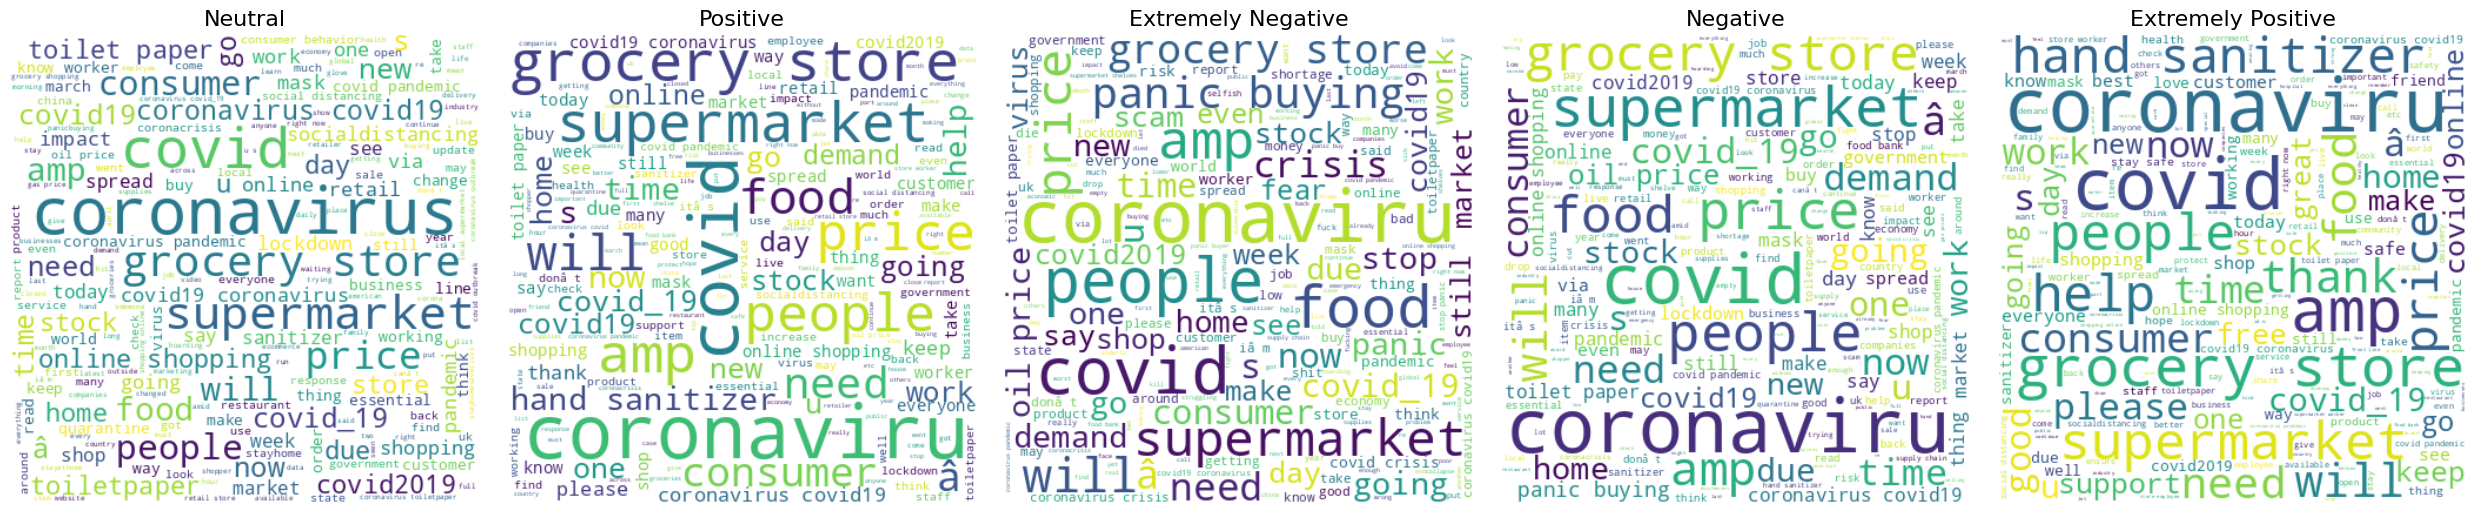

In [20]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample DataFrame


# Optional: lowercasing and basic cleaning
word_cloud_df['clean_text'] = word_cloud_df['OriginalTweet'].str.lower()

# Unique sentiments
sentiments = word_cloud_df['Sentiment'].unique()
to_remove = "http"

def delete_words_with_http(text, to_remove):

    if not isinstance(text, str): # בדיקה שהקלט הוא מחרוזת (למקרה של ערכי NaN וכו')
        return text

    words = text.split() # פיצול הטקסט למילים (מטפל גם ברווחים כפולים)

    # יצירת רשימה חדשה של מילים, ללא המילים שמכילות את רצף האותיות
    kept_words = [word for word in words if to_remove not in word]

    return ' '.join(kept_words) # חיבור המילים הנותרות בחזרה למחרוזת עם רווחים בודדים

word_cloud_df['clean_text'] = word_cloud_df['clean_text'].apply(lambda x: delete_words_with_http(x, to_remove))

# Plot word clouds
fig, axs = plt.subplots(1, len(sentiments), figsize=(5 * len(sentiments), 5))

if len(sentiments) == 1:
    axs = [axs]  # make iterable

for i, sentiment in enumerate(sentiments):
    text_blob = " ".join(word_cloud_df[word_cloud_df['Sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='viridis').generate(text_blob)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(sentiment, fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


The word cloud **did not show** any substantial differances between the topics of tweets under all sentiment categories